In [5]:
import sys
import importlib
import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
base_path = "../src/"
sys.path.append(base_path)
import models
import train
from losses import *

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
#datafilename='../../DATA/data_L25LH_TNG.hdf5'
datafilename='../../DATA/data_L50_TNG_v3.hdf5'
with h5py.File(datafilename, 'r') as f:
    print("Datasets available:")
    for key in f.keys():
        print(key)

with h5py.File(datafilename, 'r') as f:
    #Parameters = f['Parameters'][0, :1024].T.reshape(-1, 1)
    Parameters = f['Parameters'][:, :1024].T
#logflag = np.array([False])
#logflag = np.array([False, False, True, True, True, True])
logflag = np.array([False, False, True, True, True, True, False, False, False, True, True, False, False, True, False, True, False, True, True, False, False, True, True, True, True, True, True, False, True, False, True, False, False, False, True])
logflag = logflag[:Parameters.shape[1]]
origParameters = Parameters
if not np.all(Parameters[:, logflag] > 0):
    raise ValueError("Some values to be logged are non-positive.")
PartiallyLoggedParameters = Parameters.copy()
PartiallyLoggedParameters[:, logflag] = np.log(PartiallyLoggedParameters[:, logflag])
means = PartiallyLoggedParameters.mean(axis=0)
stds = PartiallyLoggedParameters.std(axis=0)
Parameters = (PartiallyLoggedParameters - means) / stds
#print(Parameters.shape)
#print(Parameters.dtype)
#print(Parameters.min(axis=0))
#print(Parameters.max(axis=0))

with h5py.File(datafilename, 'r') as f:
    Ms_Mh_s90 = f['Ms_Mh_s90'][:].T
    Ms_Mh_s61 = f['Ms_Mh_s61'][:].T
    MBH_Mh_s90 = f['MBH_Mh_s90'][:].T
    MBH_Mh_s61 = f['MBH_Mh_s61'][:].T
    Mg_Mh_s90 = f['Mg_Mh_s90'][:].T
    Mg_Mh_s61 = f['Mg_Mh_s61'][:].T
    Rs_Ms_s90 = f['Rs_Ms_s90'][:].T
    Rs_Ms_s61 = f['Rs_Ms_s61'][:].T
    SFR_Ms_s90 = f['SFR_Ms_s90'][:].T
    SFR_Ms_s61 = f['SFR_Ms_s61'][:].T
    Zs_Ms_s90 = f['Zs_Ms_s90'][:].T
    Zs_Ms_s61 = f['Zs_Ms_s61'][:].T
    SFRH_100Myr = f['SFRH_100Myr'][:].T

Datasets available:
MBH_Mh_s61
MBH_Mh_s90
Mg_Mh_s61
Mg_Mh_s90
Ms_Mh_s61
Ms_Mh_s90
Parameters
Rs_Ms_s61
Rs_Ms_s90
SFRH
SFRH_100Myr
SFRH_z
SFR_Ms_s61
SFR_Ms_s90
Zs_Ms_s61
Zs_Ms_s90
logMh_s61
logMh_s90
logMs_s61
logMs_s90


In [9]:
#x = torch.from_numpy(Ms_Mh_s90).float()
#x = torch.cat((torch.from_numpy(Ms_Mh_s90), torch.from_numpy(Ms_Mh_s61)), dim=1).float()
#x = torch.cat((torch.from_numpy(Ms_Mh_s90), torch.from_numpy(Ms_Mh_s61), torch.from_numpy(MBH_Mh_s90), torch.from_numpy(MBH_Mh_s61), torch.from_numpy(Mg_Mh_s90), torch.from_numpy(Mg_Mh_s61)), dim=1).float()
x = torch.cat((torch.from_numpy(Ms_Mh_s90), torch.from_numpy(Ms_Mh_s61), torch.from_numpy(MBH_Mh_s90), torch.from_numpy(MBH_Mh_s61), torch.from_numpy(Mg_Mh_s90), torch.from_numpy(Mg_Mh_s61), torch.from_numpy(Rs_Ms_s90), torch.from_numpy(Rs_Ms_s61), torch.from_numpy(SFR_Ms_s90), torch.from_numpy(SFR_Ms_s61), torch.from_numpy(Zs_Ms_s90), torch.from_numpy(Zs_Ms_s61), torch.from_numpy(SFRH_100Myr)), dim=1).float()

print("Total NaNs:", torch.isnan(x).sum().item())
print("Total Infs:", torch.isinf(x).sum().item())
x[torch.isnan(x)] = 11
x[torch.isinf(x)] = 11
print("Total NaNs:", torch.isnan(x).sum().item())
print("Total Infs:", torch.isinf(x).sum().item())
y = torch.from_numpy(Parameters).float()
print(x.shape)
print(y.shape)
#print(x.dtype)
#print(y.dtype)
#print(x[1:3,:])
#print(y[1:3,:])

Total NaNs: 0
Total Infs: 0
Total NaNs: 0
Total Infs: 0
torch.Size([1024, 253])
torch.Size([1024, 35])


In [10]:
# Hyperparameters
input_dim    = x.shape[1]
output_dim   = y.shape[1]
hidden_dims  = [128, 64]
#hidden_dims  = [128, 64, 64]
#hidden_dims  = [64, 64]
lr           = 1e-4
wd           = 1e-5
dropout_rate = 0.2
epochs       = 2000
val_fraction = 0.1
batch_size   = 64

In [11]:
full_dataset = TensorDataset(x, y)

# -- split into train / val --
n_val   = int(len(full_dataset) * val_fraction)
n_train = len(full_dataset) - n_val
train_ds, val_ds = random_split(full_dataset, [n_train, n_val])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

In [12]:
importlib.reload(train)
importlib.reload(models)

<module 'models' from '/mnt/ceph/users/sgenel/CAMELS/gal_sbi/camelsPE/jupyter_notebook/../src/models.py'>

In [13]:
# model, optimizer, loss function
model     = models.SimpleMLP(input_dim, hidden_dims, output_dim, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
criterion = MSELoss()

In [14]:
train_losses, val_losses = train.fit(model, train_loader, val_loader, optimizer, criterion, device, epochs)

Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter   50] validation loss: 0.9886
[Iter  100] validation loss: 0.9375
[Iter  150] validation loss: 0.9138
[Iter  200] validation loss: 0.9021
[Iter  250] validation loss: 0.8915
[Iter  300] validation loss: 0.8804
[Iter  350] validation loss: 0.8749
[Iter  400] validation loss: 0.8672
[Iter  450] validation loss: 0.8633
[Iter  500] validation loss: 0.8596
[Iter  550] validation loss: 0.8560
[Iter  600] validation loss: 0.8506
[Iter  650] validation loss: 0.8479
[Iter  700] validation loss: 0.8453
[Iter  750] validation loss: 0.8433
[Iter  800] validation loss: 0.8416
[Iter  850] validation loss: 0.8396
[Iter  900] validation loss: 0.8343
[Iter  950] validation loss: 0.8366
[Iter 1000] validation loss: 0.8330
[Iter 1050] validation loss: 0.8318
[Iter 1100] validation loss: 0.8293
[Iter 1150] validation loss: 0.8259
[Iter 1200] validation loss: 0.8254
[Iter 1250] validation loss: 0.8262
[Iter 1300] validation loss: 0.8219
[Iter 1350] validation loss: 0.8221
[Iter 1400] validation loss:

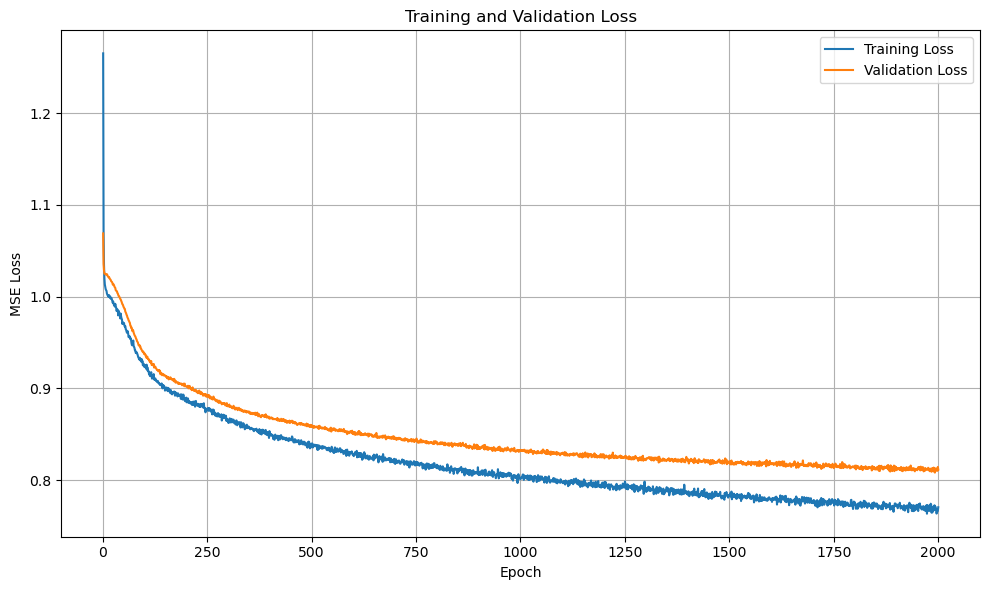

In [15]:
plt.figure(figsize=(10, 6))
epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../../training_plot.png")
plt.show()

In [16]:
model.eval()
predictions, true_values = [], []

with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        
        predictions.append(preds.cpu())
        true_values.append(yb.cpu())

all_predictions = torch.cat(predictions).numpy()
all_true_values = torch.cat(true_values).numpy()

all_predictions = all_predictions * stds + means
all_true_values = all_true_values * stds + means
all_predictions[:, logflag] = np.exp(all_predictions[:, logflag])
all_true_values[:, logflag] = np.exp(all_true_values[:, logflag])

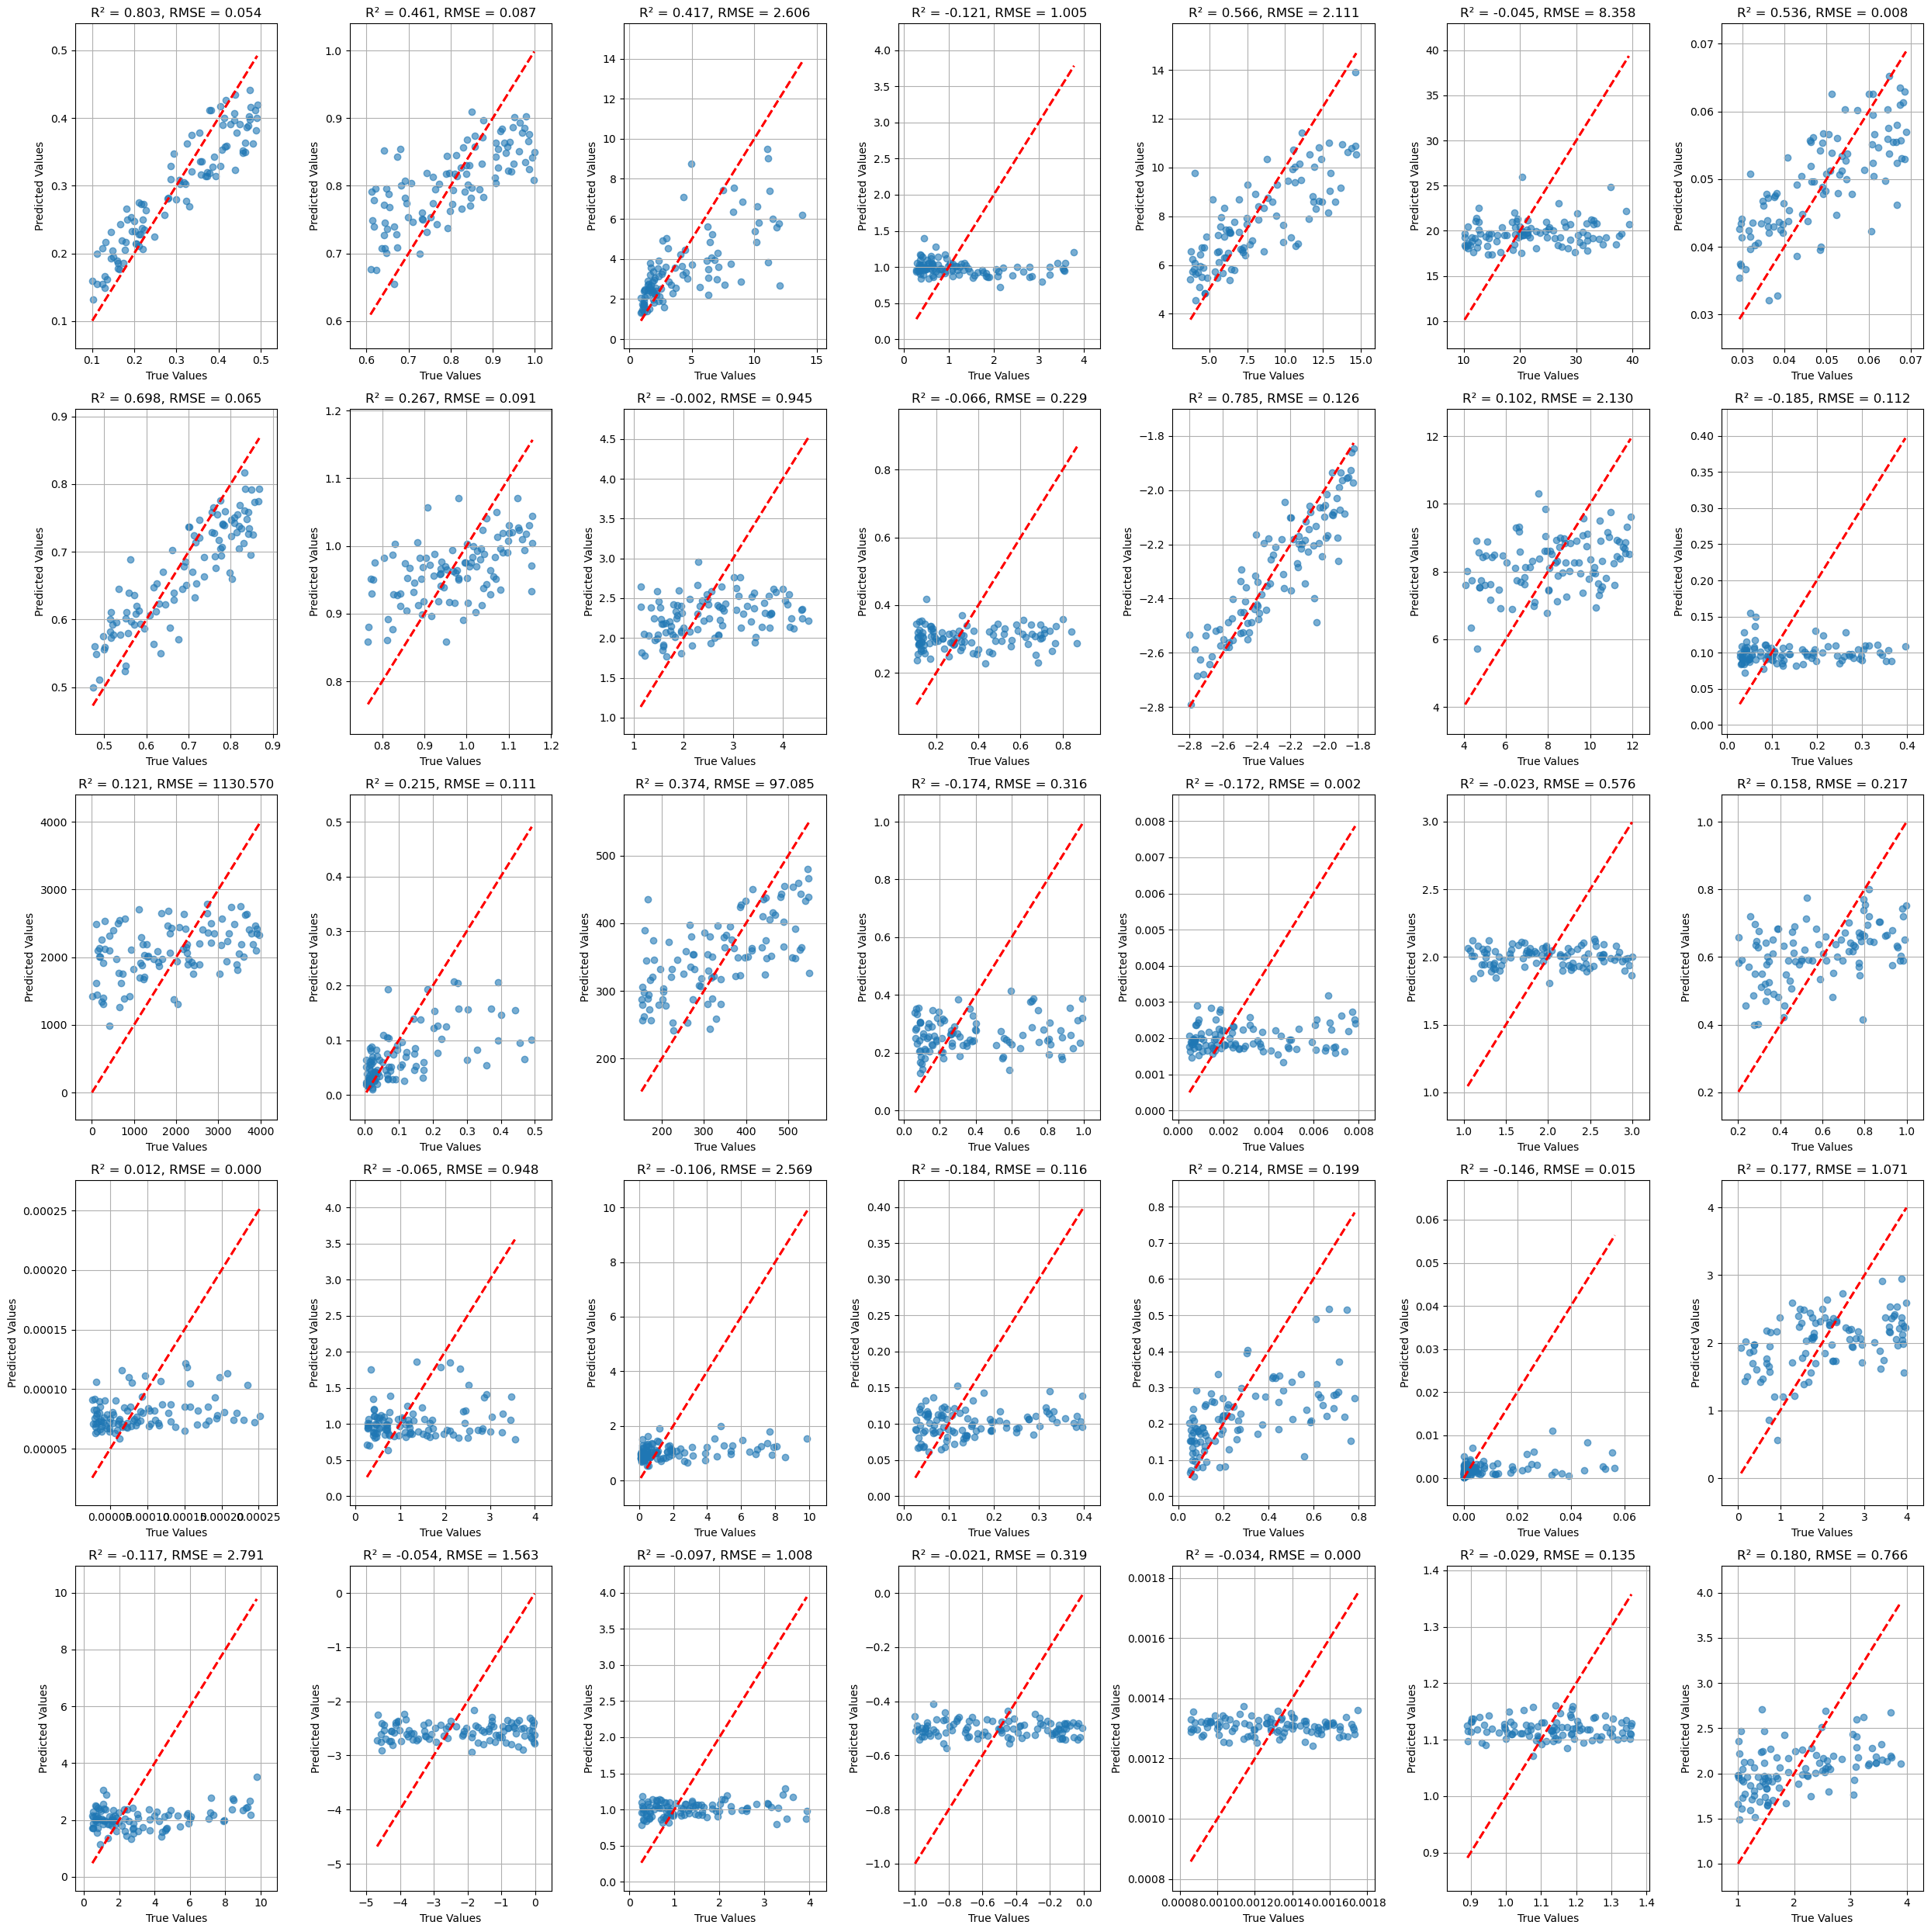

In [17]:
# Create figure with subplots
Npanels=[5,7]
#Npanels=[3,2]
fig, axes = plt.subplots(nrows=Npanels[0], ncols=Npanels[1], figsize=(25,25))
for i in range(Npanels[0]):
    for j in range(Npanels[1]):
        ax = axes[i, j]

        predictions = all_predictions[:,i*Npanels[1]+j]
        true_values = all_true_values[:,i*Npanels[1]+j]
        
        ax.scatter(true_values, predictions, alpha=0.6)
        r2 = r2_score(true_values, predictions)
        rmse = np.sqrt(mean_squared_error(true_values, predictions))

        # Plotting ideal prediction line
        min_val = min(true_values.min(), predictions.min())
        max_val = max(true_values.max(), predictions.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

        ax.set_xlabel('True Values')
        ax.set_ylabel('Predicted Values')
        ax.set_title(f'R² = {r2:.3f}, RMSE = {rmse:.3f}')
        ax.grid(True)
        ax.set_xlim(origParameters.min(axis=0)[i*Npanels[1]+j]-(origParameters.max(axis=0)[i*Npanels[1]+j]-origParameters.min(axis=0)[i*Npanels[1]+j])*0.1, origParameters.max(axis=0)[i*Npanels[1]+j]+(origParameters.max(axis=0)[i*Npanels[1]+j]-origParameters.min(axis=0)[i*Npanels[1]+j])*0.1)
        ax.set_ylim(origParameters.min(axis=0)[i*Npanels[1]+j]-(origParameters.max(axis=0)[i*Npanels[1]+j]-origParameters.min(axis=0)[i*Npanels[1]+j])*0.1, origParameters.max(axis=0)[i*Npanels[1]+j]+(origParameters.max(axis=0)[i*Npanels[1]+j]-origParameters.min(axis=0)[i*Npanels[1]+j])*0.1)

plt.tight_layout()
plt.savefig("../../results_plot.png")
plt.show()

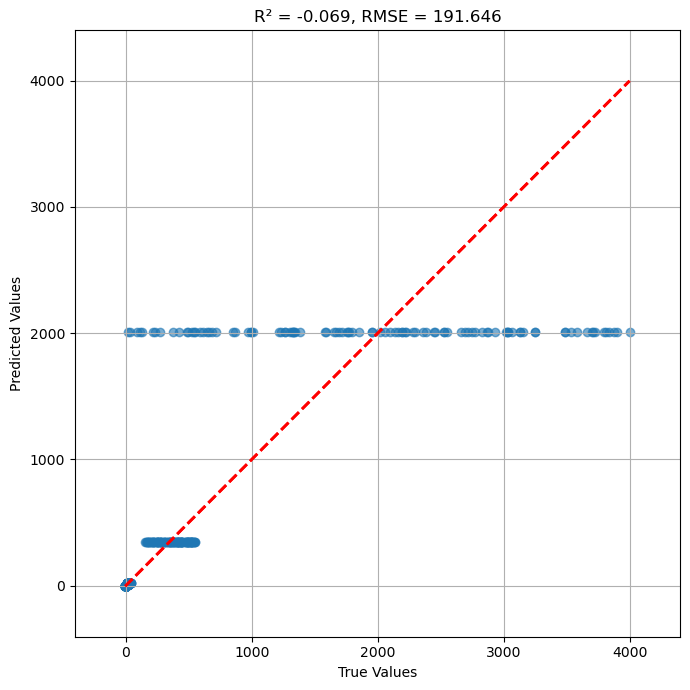

In [580]:
# for the case of just one output

predictions = all_predictions
true_values = all_true_values

r2 = r2_score(true_values, predictions)
rmse = np.sqrt(mean_squared_error(true_values, predictions))

plt.figure(figsize=(7, 7))
plt.scatter(true_values, predictions, alpha=0.6)

# Plotting ideal prediction line
min_val = min(true_values.min(), predictions.min())
max_val = max(true_values.max(), predictions.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title(f'R² = {r2:.3f}, RMSE = {rmse:.3f}')
plt.grid(True)
plt.xlim(origParameters.min()-(origParameters.max()-origParameters.min())*0.1, origParameters.max()+(origParameters.max()-origParameters.min())*0.1)
plt.ylim(origParameters.min()-(origParameters.max()-origParameters.min())*0.1, origParameters.max()+(origParameters.max()-origParameters.min())*0.1)
plt.tight_layout()
plt.show()